In [3]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import sys

sys.path.append("..")
sys.path.append("../..")
from samples.CLS2IDX import CLS2IDX
#

# Auxiliary Functions

In [4]:
from ViT_LRP import deit_base_patch16_224_retrained as vit_LRP
from ViT_explanation_generator import LRP
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
normalize = transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained with DeiT
model = vit_LRP(pretrained=True).a.cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    num_cls_token = transformer_attribution.size(1) - 14*14
    print(num_cls_token, transformer_attribution.shape)
    transformer_attribution = transformer_attribution[:,num_cls_token:].reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_deit_main


Top 5 classes:
	292 : tiger, Panthera tigris            		value = 4.322	 prob = 3.1%
	572 : goblet                            		value = 4.238	 prob = 2.8%
	251 : dalmatian, coach dog, carriage dog		value = 4.143	 prob = 2.6%
	242 : boxer                             		value = 4.010	 prob = 2.2%
	512 : corkscrew, bottle screw           		value = 3.947	 prob = 2.1%
1 torch.Size([1, 197])


c:\users\rober\anaconda3\envs\ml\lib\site-packages\torch\nn\functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


1 torch.Size([1, 197])


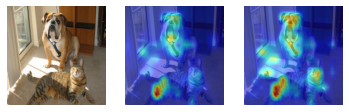

In [5]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# dog 
# generate visualization for class 243: 'bull mastiff' - the predicted class
dog = generate_visualization(dog_cat_image)

# cat - generate visualization for class 282 : 'tiger cat'
cat = generate_visualization(dog_cat_image, class_index=282)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');

Top 5 classes:
	600 : hook, claw                		value = 5.727	 prob = 10.7%
	352 : impala, Aepyceros melampus		value = 4.856	 prob = 4.5%
	745 : projector                 		value = 4.587	 prob = 3.4%
	353 : gazelle                   		value = 4.464	 prob = 3.0%
	711 : perfume, essence          		value = 3.957	 prob = 1.8%
1 torch.Size([1, 197])
1 torch.Size([1, 197])


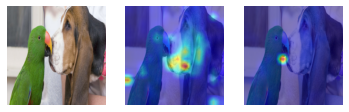

In [6]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 90: 'lorikeet'
parrot = generate_visualization(dog_bird_image, class_index=90)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

Top 5 classes:
	340 : zebra                               		value = 8.919	 prob = 76.5%
	385 : Indian elephant, Elephas maximus    		value = 5.143	 prob = 1.8%
	351 : hartebeest                          		value = 4.815	 prob = 1.3%
	101 : tusker                              		value = 4.712	 prob = 1.1%
	386 : African elephant, Loxodonta africana		value = 4.153	 prob = 0.7%
1 torch.Size([1, 197])
1 torch.Size([1, 197])


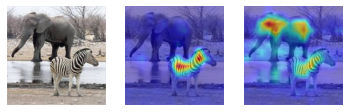

In [7]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# zebra
# zebra- the predicted class
zebra = generate_visualization(tusker_zebra_image, class_index=340)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization(tusker_zebra_image, class_index=101)

axs[1].imshow(zebra)
axs[1].axis('off')
axs[2].imshow(tusker)
axs[2].axis('off')


Top 5 classes:
	222 : kuvasz            		value = 8.258	 prob = 43.0%
	207 : golden retriever  		value = 6.898	 prob = 11.0%
	181 : Bedlington terrier		value = 6.883	 prob = 10.9%
	208 : Labrador retriever		value = 5.593	 prob = 3.0%
	257 : Great Pyrenees    		value = 5.234	 prob = 2.1%
1 torch.Size([1, 197])
1 torch.Size([1, 197])


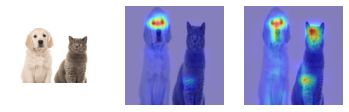

In [8]:
image = Image.open('samples/dogcat2.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# golden retriever - the predicted class
dog = generate_visualization(dog_cat_image)

# generate visualization for class 285: 'Egyptian cat'
cat = generate_visualization(dog_cat_image, class_index=285)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');